In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from keras.preprocessing import image

In [2]:
SHAPE = 80
EPOCHS = 50 
NUM_CLASSES = 7

In [3]:
# Configure the training image generator
TRAINING_DIR = "./data/train/"
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Configure the validation image generator
VALIDATION_DIR = "./data/test/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Set the image size and batch size for training and validation
# generators 
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(SHAPE,SHAPE),
    class_mode='categorical',
    batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(SHAPE,SHAPE),
    class_mode='categorical',
    batch_size=64
)

Found 7600 images belonging to 7 classes.
Found 1860 images belonging to 7 classes.


In [89]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)

AttributeError: 'DirectoryIterator' object has no attribute 'cache'

# Image informations

In [4]:
class_names = list(validation_generator.class_indices.keys())

print(class_names)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


# Model creation

In [5]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image SHAPExSHAPE with
    # 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(SHAPE, SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128 , (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

# Training

In [8]:
model.compile(loss = 'categorical_crossentropy', optimizer='NAdam', metrics=['accuracy'])

history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=100, validation_data = validation_generator)

model.save("trained_models/emotion_NAdam.h5")

Epoch 1/50
100/100 [==============================] - 24s 233ms/step - loss: 1.8425 - accuracy: 0.2583 - val_loss: 1.8135 - val_accuracy: 0.2726
Epoch 2/50
100/100 [==============================] - 8s 81ms/step - loss: 1.7740 - accuracy: 0.2962 - val_loss: 1.6686 - val_accuracy: 0.3801
Epoch 3/50
100/100 [==============================] - 6s 64ms/step - loss: 1.7162 - accuracy: 0.3390 - val_loss: 1.5457 - val_accuracy: 0.4188
Epoch 4/50
100/100 [==============================] - 7s 65ms/step - loss: 1.6390 - accuracy: 0.3637 - val_loss: 1.4454 - val_accuracy: 0.4403
Epoch 5/50
100/100 [==============================] - 6s 64ms/step - loss: 1.5764 - accuracy: 0.3913 - val_loss: 1.3966 - val_accuracy: 0.4817
Epoch 6/50
100/100 [==============================] - 6s 63ms/step - loss: 1.5122 - accuracy: 0.4251 - val_loss: 1.2918 - val_accuracy: 0.5108
Epoch 7/50
100/100 [==============================] - 6s 65ms/step - loss: 1.4509 - accuracy: 0.4522 - val_loss: 1.3009 - val_accuracy: 0.49

In [9]:
test_loss, test_acc = model.evaluate(validation_generator)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

30/30 [==============================] - 1s 15ms/step - loss: 0.7478 - accuracy: 0.7430

Test accuracy: 0.7430107593536377

Test loss: 0.7478460669517517


# History

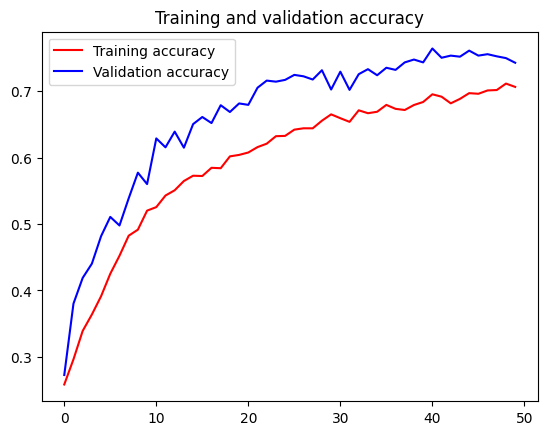

<Figure size 640x480 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Validation

In [98]:
uploaded = ["./data/uploaded/neutral.jpg"]
img_class = 4

img = tf.keras.utils.load_img(
    uploaded[0], target_size=(SHAPE, SHAPE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [54]:
predictions_self = model.predict(img_array)
print(predictions_self)

score = tf.nn.softmax(predictions_self[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
[[0. 0. 0. 0. 0. 0. 1.]]
This image most likely belongs to surprise with a 31.18 percent confidence.


In [55]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(img_array)

print(predictions[0])
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 59ms/step
[0.11470149 0.11470149 0.11470149 0.11470149 0.11470149 0.11470149
 0.31179097]
6


In [11]:
def plot_image(predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label],
                                color=color)
                                )

def plot_value_array(i, predictions_array, true_label):
  plt.grid(False)
  plt.xticks(range(7))
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

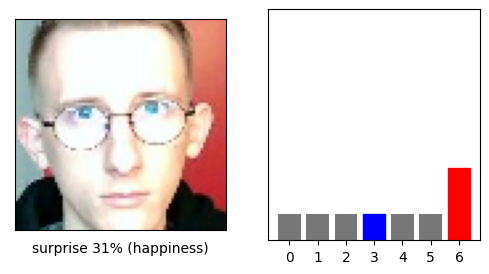

In [57]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(predictions[i], 3, img)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  3 )
plt.show()

# Validate all Data


1/1 [==============================] - 0s 46ms/step
[[1. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 46ms/step


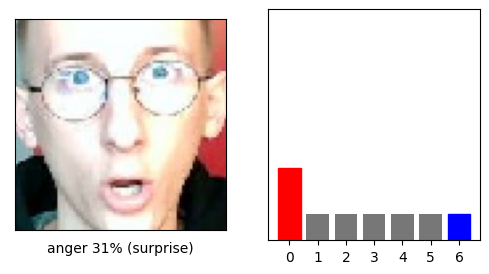

1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 46ms/step


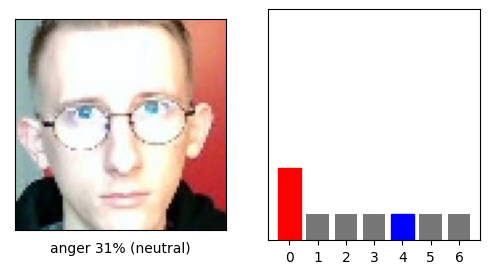

1/1 [==============================] - 0s 15ms/step
[[1. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 46ms/step


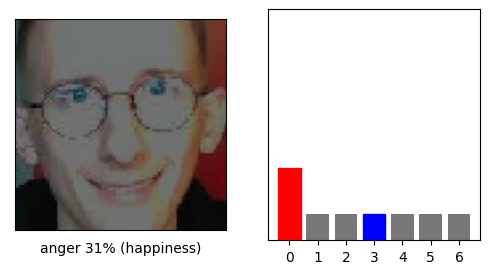

1/1 [==============================] - 0s 16ms/step
[[0. 0. 1. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 67ms/step


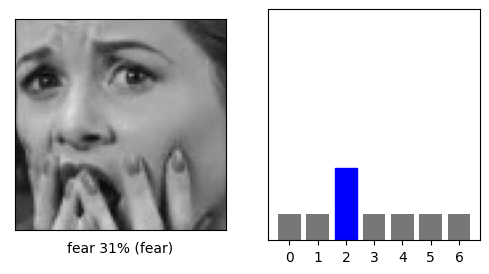

1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 61ms/step


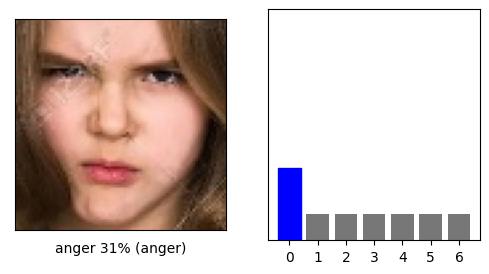

1/1 [==============================] - 0s 15ms/step
[[1. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 49ms/step


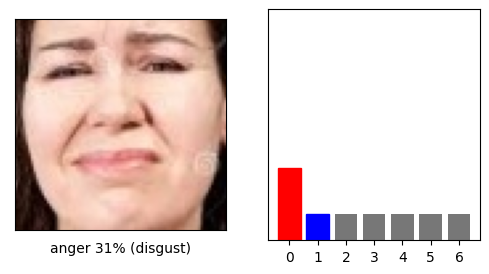

1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 47ms/step


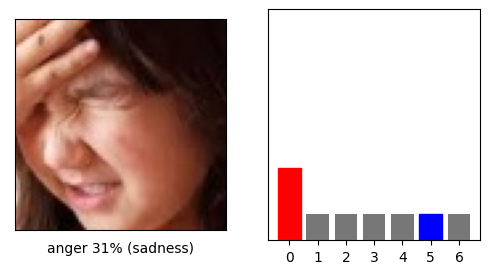

1/1 [==============================] - 0s 18ms/step
[[5.460766e-24 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]]
1/1 [==============================] - 0s 48ms/step


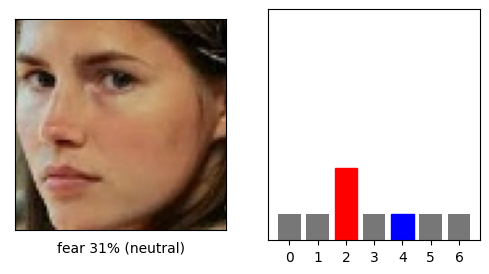

In [13]:
uploaded = [
    "./data/uploaded/suprised.jpg",
    "./data/uploaded/neutral.jpg",
    "./data/uploaded/happy.jpg",
    "./data/uploaded/fear12.jpg",
    "./data/uploaded/anger1.jpg",
    "./data/uploaded/disgust1.jpg",
    "./data/uploaded/sadness1.jpg",
    "./data/uploaded/neutral6.jpg"
]
# 0: Anger, 1: Disgust, 2: Fear, 3: Happy, 4: Neutral, 5: Sad, 6: Surprise
img_class = [6, 4, 3, 2, 0, 1, 5, 4]
model = tf.keras.models.load_model("trained_models/emotion_NAdam.h5")

img = []
img_array = []
predictions_self = []

for i in range(len(uploaded)):
    img.append(tf.keras.utils.load_img(
        uploaded[i], target_size=(SHAPE, SHAPE)
    ))
    img_array.append(tf.keras.utils.img_to_array(img[i]))
    img_array[i] = tf.expand_dims(img_array[i], 0) # Create a batch
    predictions_self.append(model.predict(img_array[i]))
    print(predictions_self[i])

    score = tf.nn.softmax(predictions_self[i])

    # print(
    #     "This image most likely belongs to {} with a {:.2f} percent confidence."
    #     .format(class_names[np.argmax(score)], 100 * np.max(score))
    # )

    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

    predictions = probability_model.predict(img_array[i])

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(predictions[0], img_class[i], img[i])
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[0],  img_class[i])
    plt.show()

    
    